In [1]:
import torch 
import numpy as np
import matplotlib.pyplot as plt 

In [2]:
def gauss(x, mean, var):
    return np.exp(-0.5 * np.power(x - mean, 2)/var)/np.sqrt(var * 2 * np.pi) 

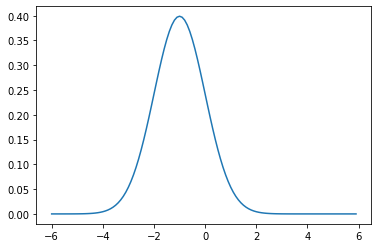

In [3]:
x = np.arange(-6,6,0.1)
plt.plot(x, gauss(x, -1, 1))

## Generate Data

In [4]:

m = 120000
mu = 0
var = 1.0
sd = np.sqrt(var)
p_data = np.random.default_rng().normal(mu, sd, size=m)

In [5]:
p_data.shape

(120000,)

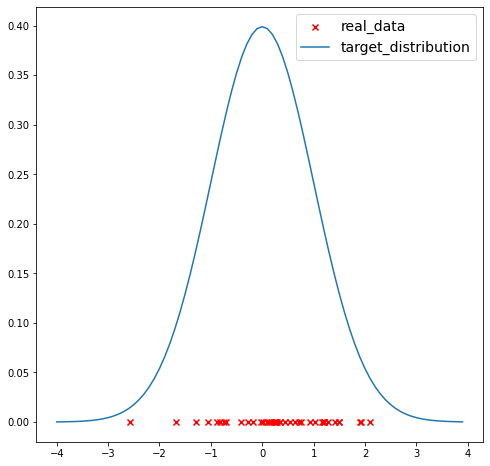

In [6]:
np.random.shuffle(p_data)
batch_size = 40
plt.figure(figsize=(8,8))
plt.scatter(p_data[0:batch_size], np.zeros(batch_size), c='red', marker="x", label="real_data")
x = np.arange(-4,4,0.1)
plt.plot(x, gauss(x, mu, var), label="target_distribution")
plt.legend(prop={'size':14})

NameError: name 'z' is not defined